In [66]:
import pandas as pd
import json
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
from sklearn.model_selection import train_test_split
from random import randrange
import math
import os 
import networkx as nx
from networkx.algorithms import community
!pip install python-louvain
from community import community_louvain
import matplotlib.cm as cm



You should consider upgrading via the 'c:\users\caspe\anaconda3\python.exe -m pip install --upgrade pip' command.


In [67]:
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)
    

In [68]:
def load_all_cities():

    directory = os.path.realpath('.') + '\\data'

    cities = [x[0].split('\\')[-1] for x in os.walk(directory)][1:]

    amount = 0

    for city in cities:
        data_path = './data/' + city + '/'
        if amount == 0:
            reviews = load_jsons(data_path, review_file)
            businesses = load_jsons(data_path, business_file)
            users = load_jsons(data_path, user_file)
            tips = load_jsons(data_path, tip_file)
            checkins = load_jsons(data_path, checkin_file)
        else:
            reviews = pd.concat([reviews, load_jsons(data_path, review_file)], ignore_index=True)
            businesses = pd.concat([businesses, load_jsons(data_path, business_file)], ignore_index=True)
            users = pd.concat([users, load_jsons(data_path, user_file)], ignore_index=True)
            tips = pd.concat([tips, load_jsons(data_path, tip_file)], ignore_index=True)
            checkins = pd.concat([checkins, load_jsons(data_path, checkin_file)], ignore_index=True)
                
        amount += 1
        if amount == 20:
            break
    return reviews, businesses, users, tips, checkins


In [69]:
def load_city():
    # Load data for town called Ambridge
    data_path = './data/york/'

    reviews = load_jsons(data_path, review_file)[['business_id', 'user_id', 'stars']]
    businesses = load_jsons(data_path, business_file)
    users = load_jsons(data_path, user_file)
    tips = load_jsons(data_path, tip_file)
    checkins = load_jsons(data_path, checkin_file)

    return reviews, businesses, users, tips, checkins

In [70]:
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews, businesses, users, tips, checkins = load_all_cities()

Drop duplicate entries

In [71]:
reviews = reviews.groupby(['business_id', 'user_id']).mean().reset_index()

Create an utility matrix

In [72]:
def pivot_ratings(reviews):
    """ 
    Takes a rating table as input and computes the utility matrix using pandas pivot function.
    """
    
    return reviews.pivot(index = 'business_id', columns = 'user_id', values = 'stars') 


Create similarity matrix

In [73]:
def create_similarity_matrix_cosine(utility_matrix, method):
    """ 
    Creates similarity matrix from the utility matrix. 
    """
    # mean center the matrix first
    utility_matrix = utility_matrix - utility_matrix.mean()

    if method == 'avg':
        utility_matrix = utility_matrix.T.fillna(utility_matrix.mean(axis=1)).T
    elif method == 'overall':
        overall_avg = reviews['stars'].mean()
        utility_matrix = utility_matrix.fillna(overall_avg)
    elif method == '3':
        utility_matrix = utility_matrix.fillna(3)

    # sklearn needs a ndarray as input, so convert the matrix
    matrix = np.array(utility_matrix)

    similarities = cosine_similarity_sklearn(matrix)

    # convert the output back to a pandas dataframe
    similarity_matrix = pd.DataFrame(data=similarities[0:,0:],
                                    index=utility_matrix.index,
                                    columns=utility_matrix.index)

    return similarity_matrix


In [74]:
def select_neighborhood(similarities, reviews, k):
    """ selects all items with similarity > 0  """

    reviewed_businesses = reviews.notnull()
    similarities = similarities[similarities > 0]
    neighborhood = similarities[reviewed_businesses == True].sort_values(ascending=False)

    return neighborhood[:k]


In [75]:
def weighted_mean(neighborhood, reviews):  

    if neighborhood.empty:
        return 3

    numerator = neighborhood * reviews
    return numerator.sum() / neighborhood.sum()


In [76]:
def predict(business_id, user_id, utility_matrix, similarity):

    if user_id in utility_matrix.columns and business_id in similarity.index:
        neighborhood = select_neighborhood(similarity[business_id], utility_matrix[user_id], 15)
        prediction = weighted_mean(neighborhood, utility_matrix[user_id])
    else:
        return 3

    return prediction


In [77]:
def predict_ratings(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()

    for row in ratings_test_c.iterrows():
        user = row[1]["user_id"]
        business = row[1]["business_id"]

        prediction = predict(business, user, utility, similarity)

        ratings_test_c.loc[row[0], 'stars_predicted'] = prediction

    return ratings_test_c


In [78]:
reviews_training, reviews_test = train_test_split(reviews, test_size=0.2)

In [79]:
utility_matrix = pivot_ratings(reviews_training)

similarity_avg = create_similarity_matrix_cosine(utility_matrix, 'avg')
similarity_overall = create_similarity_matrix_cosine(utility_matrix, 'overall')
similarity_3 = create_similarity_matrix_cosine(utility_matrix, '3')

predictions_avg = predict_ratings(similarity_avg, utility_matrix, reviews_test)
predictions_overall = predict_ratings(similarity_overall, utility_matrix, reviews_test)
predictions_3 = predict_ratings(similarity_3, utility_matrix, reviews_test)



----------------------- evaluation -----------------------------

In [80]:
def mse(predicted_stars):
    squared_error = (predicted_stars['stars'] - predicted_stars['stars_predicted'])**2
    return sum(squared_error)/len(squared_error)   

# random predictions
predictions_random = reviews_test.copy()
predictions_random['stars_predicted'] = np.random.uniform(1, 5.0, predictions_random.shape[0])

print('mse avg method:', mse(predictions_avg))
print('mse 3 method:', mse(predictions_3))
print('mse overall method:', mse(predictions_overall))
print('mse random method:', mse(predictions_random))

mse avg method: 2.613517396292988
mse 3 method: 2.611997990180318
mse overall method: 2.6123579329982785
mse random method: 3.8996853982506976


Precision en recall

In [81]:
def recommended(predictions, threshold):
    predictions = predictions[predictions['stars_predicted'] >= threshold]
    predictions = predictions[['user_id', 'business_id']]
    return predictions
    

def hidden(predictions, threshold):
    predictions = predictions[predictions['stars_predicted'] < threshold]
    predictions = predictions[['user_id', 'business_id']]
    return predictions
    


In [82]:
def used(predictions, threshold):
    predictions = predictions[predictions['stars'] >= threshold]
    predictions = predictions[['user_id', 'business_id']]
    return predictions
    

def unused(predictions, threshold):
    predictions = predictions[predictions['stars'] < threshold]
    predictions = predictions[['user_id', 'business_id']]
    return predictions
    


In [83]:
def confusion(recommended, hidden, used, unused):
    TP = pd.merge(recommended, used, indicator=True, how='outer')
    TP = TP[TP['_merge'] == 'both'].shape[0]

    FP = pd.merge(recommended, unused, indicator=True, how='outer')
    FP = FP[FP['_merge'] == 'both'].shape[0]

    TN = pd.merge(hidden, unused, indicator=True, how='outer')
    TN = TN[TN['_merge'] == 'both'].shape[0]

    FN = pd.merge(hidden, used, indicator=True, how='outer')
    FN = FN[FN['_merge'] == 'both'].shape[0]

    return pd.DataFrame([[TP, FP], [FN, TN]], index=['recommended', 'hidden'], columns=['used', 'unused'])
    



In [84]:
def precision(confusion_matrix):
    TP = confusion_matrix.loc['recommended'].at['used']
    FP = confusion_matrix.loc['recommended'].at['unused']
    return TP / (TP + FP)
    

In [85]:
def recall(confusion_matrix):
    TP = confusion_matrix.loc['recommended'].at['used']
    FN = confusion_matrix.loc['hidden'].at['used']
    return TP / (TP + FN)


In [86]:
def prec_rec(treshold_recommended, treshold_used, predicted):

    recommended_items = recommended(predicted, treshold_recommended)
    hidden_items = hidden(predicted, treshold_recommended)

    used_items = used(predicted, treshold_used)
    unused_items = unused(predicted, treshold_used)

    confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
    prec = precision(confusion_matrix)
    rec = recall(confusion_matrix)

    return prec, rec


In [87]:

def evaluate(predictions, label):

    treshold_used = 4
    thres_rec = np.arange(3, 5, 0.5)

    # item based
    precision_item_based = [prec_rec(i, treshold_used, predictions)[0] for i in thres_rec]
    recall_item_based = [prec_rec(i, treshold_used, predictions)[1] for i in thres_rec]

    plt.plot(recall_item_based, precision_item_based, label=label)
    plt.xlabel('recall')
    plt.ylabel('precision')
    for r, p, t in zip(recall_item_based, precision_item_based, thres_rec):
        plt.text(r, p, t)



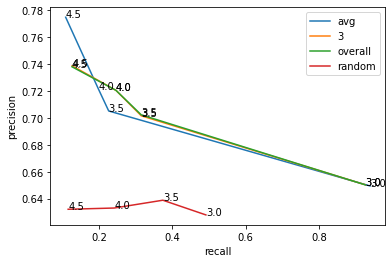

In [88]:
evaluate(predictions_avg, 'avg')
evaluate(predictions_3, '3')
evaluate(predictions_overall, 'overall')
evaluate(predictions_random, 'random')

plt.legend()
plt.show()

Now we diversify the recommendations by clustering

First we put the categories in a network/graph

In [89]:

categories = businesses[businesses['categories'].notnull()]['categories'].copy()
G = nx.Graph()

all_categories = []
for i in categories.index:
    new_category = []
    sentence = categories[i]
    a = []

    for category in sentence.split():
        category_list = []
        
        for word in category.split():
            for w in word.split('/'):
                w = w.split(',')[0]
                if w == '&':
                    continue

                if w not in all_categories:
                    all_categories.append(w)
                    G.add_node(w)
                
                a.append(w)
        
    for cat1 in a:
        for cat2 in a:
            if cat1 != cat2:
                if not G.has_edge(cat1, cat2) and not G.has_edge(cat2, cat1):
                    G.add_edge(cat1, cat2, weight=1)
                elif G.has_edge(cat1, cat2):
                    weight = G[cat1][cat2]['weight']
                    G[cat1][cat2]['weight'] = weight + 1
                elif G.has_edge(cat2, cat1):
                    weight = G[cat2][cat1]['weight']
                    G[cat2][cat1]['weight'] = weight + 1


In [90]:
partition = community_louvain.generate_dendrogram(G, random_state=23)
subpartition = partition[len(partition)-2]
bestpartition = partition[len(partition)-1]


In [91]:
subcluster_to_cluster = bestpartition

clusters = pd.DataFrame(columns=['category', 'subcluster', 'cluster'])

# save clusters and subclusters in a list
for key in subpartition:
    value1 = subpartition[key]
    value2 = bestpartition[value1]
    clusters.loc[len(clusters)] = [key, value1, value2]

subcluster_amount = clusters['subcluster'].max() + 1
cluster_amount = clusters['cluster'].max() + 1


In [92]:
display(clusters[clusters['subcluster'] == 3])
display(clusters)


,category,subcluster,cluster
137,Ice,3,0
138,Cream,3,0
139,Frozen,3,0
140,Yogurt,3,0
367,Chocolatiers,3,0


,category,subcluster,cluster
0,Automotive,1,3
1,Auto,1,3
2,Repair,1,3
3,Oil,1,3
4,Change,1,3
...,...,...,...
595,Brasseries,14,0
596,Trampoline,13,4
597,French,9,0
598,Ethical,9,0


Now determining which cluster each business belongs to the most

In [93]:
businesses['subcluster'] = 0
businesses['cluster'] = 0


for index, business in businesses.iterrows():

    subcluster_count = [0] * subcluster_amount
    cluster_count = [0] * cluster_amount

    categories = business['categories']

    if categories is None:
        businesses.loc[index, 'subcluster'] = randrange(0, subcluster_amount)
        businesses.loc[index, 'cluster'] = randrange(0, cluster_amount)
        continue
    for category in categories.split():
        if category == '&':
            continue
        for w in category.split('/'):
            category = w.split(',')[0]
            row = clusters[clusters['category'] == category]
            subcluster_count[row['subcluster'].values[0]] += 1
            cluster_count[row['cluster'].values[0]] += 1

    businesses.loc[index, 'subcluster'] = subcluster_count.index(max(subcluster_count))
    businesses.loc[index, 'cluster'] = cluster_count.index(max(cluster_count))

display(businesses[['business_id', 'categories', 'subcluster', 'cluster']].head())

,business_id,categories,subcluster,cluster
0,M82c96ICluambjx0wWg6Bg,"Automotive, Auto Repair, Oil Change Stations, ...",1,3
1,U_ihDw5JhfmSKBUUkpEQqw,"Burgers, Restaurants, Fast Food",9,0
2,LixFCMGKdptI8WRsjAl5cQ,"Fast Food, Restaurants, Burgers",9,0
3,064fFc4CdNxAJJDVR-7FSQ,"Home Cleaning, Professional Services, Home Ser...",15,2
4,UY1BHeeb1oE0-uk0EKqaGg,"Food, Burgers, Fast Food, Restaurants",9,0


In [94]:
def recommend(user_id, utility_matrix, similarity):
    businesses2 = businesses.copy()
    business_ids = reviews[reviews['user_id'] == user_id]['business_id']

    subcluster_count = np.zeros(subcluster_amount)
    cluster_count = np.zeros(cluster_amount)
    reviews_user = reviews[reviews['user_id']==user_id]['business_id'].values.tolist()

    for b_id in business_ids:
        row = businesses2[businesses2['business_id'] == b_id]
        subcluster_count[row['subcluster'].values[0]] += 1
        cluster_count[row['cluster'].values[0]] += 1
    to_recommend = 20

    # recommend from subclusters
    total_subcluster = sum(subcluster_count)
    weight = 3 / total_subcluster

    subcluster_count = np.array([math.ceil(element * weight) for element in subcluster_count])


    while sum(subcluster_count) > 3:
        subcluster_count[np.where( subcluster_count==np.min(subcluster_count[np.nonzero(subcluster_count)]))[0]] -= 1


    for i in np.nonzero(subcluster_count)[0]:
        amount = subcluster_count[i]

        businesses_in_cluster = businesses2[businesses2['subcluster'] == i]
        business_ids = businesses_in_cluster['business_id'].values.tolist()
        

        # make for each of these businesses a review
        predict_businesses = []
        predictions = []
        for business in business_ids:
            if business not in reviews_user:
                predict_businesses.append(business)
                predictions.append(predict(business, user_id, utility_matrix, similarity))

        # recommend for each of these clusters the top 4 for this user
        preds = pd.Series(data=predictions, index=predict_businesses).sort_values(ascending=False)
        preds = preds[:amount]
        preds = businesses2[businesses2['business_id'].isin(preds.index)]
        businesses2 = businesses2.drop(index=preds.index.values)
        recommendations = preds

        to_recommend -= len(preds)
    
    cluster_to_recommend = subcluster_to_cluster[np.argmax(subcluster_count)]
    
    businesses_in_cluster = businesses2[businesses2['cluster'] == cluster_to_recommend]
    business_ids = businesses_in_cluster['business_id'].values.tolist()
    

    # make for each of these businesses a review
    predict_businesses = []
    predictions = []
    for business in business_ids:
        if business not in reviews_user:
            predict_businesses.append(business)

            predictions.append(predict(business, user_id, utility_matrix, similarity))

    # recommend for each of these clusters the top 4 for this user
    preds = pd.Series(data=predictions, index=predict_businesses).sort_values(ascending=False)
    preds = preds[:3]
    preds = businesses2[businesses2['business_id'].isin(preds.index)]
    businesses2 = businesses2.drop(index=preds.index.values)
    recommendations = pd.concat([recommendations, preds])

    to_recommend -= len(preds)


    clusters_to_recommend = ([to_recommend // cluster_amount + (1 if x < to_recommend % cluster_amount else 0)  for x in range (cluster_amount)])

    for i, amount in enumerate(clusters_to_recommend):
        
        businesses_in_cluster = businesses2[businesses2['cluster'] == i]
        business_ids = businesses_in_cluster['business_id'].values.tolist()
        

        # make for each of these businesses a review
        predict_businesses = []
        predictions = []
        for business in business_ids:
            if business not in reviews_user:
                predict_businesses.append(business)

                predictions.append(predict(business, user_id, utility_matrix, similarity))

        # recommend for each of these clusters the top 4 for this user
        preds = pd.Series(data=predictions, index=predict_businesses).sort_values(ascending=False)
        preds = preds[:amount]
        preds = businesses2[businesses2['business_id'].isin(preds.index)]
        recommendations = pd.concat([recommendations, preds])
    
    return recommendations

def recommend_without_clusters(user_id, utility_matrix, similarity):
    businesses2 = businesses.copy()
    business_ids = reviews[reviews['user_id'] == user_id]['business_id']
    
    reviews_user = reviews[reviews['user_id']==user_id]['business_id'].values.tolist()
    business_ids = businesses2['business_id'].values.tolist()
        
    predict_businesses = []
    predictions = []
    for business in business_ids:
        if business not in reviews_user:
            predict_businesses.append(business)
            predictions.append(predict(business, user_id, utility_matrix, similarity))

    # recommend for each of these clusters the top 4 for this user
    preds = pd.Series(data=predictions, index=predict_businesses)
    preds = preds.sort_values(ascending=False)
    preds = businesses2[businesses2['business_id'].isin(preds.index)]
    businesses2 = businesses2.drop(index=preds.index.values)
    recommendations = preds

    return recommendations[:20]    
    


In [107]:
display(recommend('cFGAElozHTdQDfHimOiSBQ', utility_matrix, similarity_avg).head())
display(recommend_without_clusters('cFGAElozHTdQDfHimOiSBQ', utility_matrix, similarity_avg).head())


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subcluster,cluster
5,jEt8ed_Z2cJaBNpLG1sfsw,Hertz Rent A Car,5017 East Elliott Rd,Ahwatukee,AZ,85044,33.347910,-111.978098,2.0,29,0,None,"Hotels & Travel, Car Rental","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",1,3
854,ihx0Hvji8ZkKlOszhI0jIQ,truenorth,4035 Medina Rd,Akron,OH,44333,41.136341,-81.644547,1.5,3,1,"{'BusinessParking': '{'garage': False, 'street...","Gas Stations, Food, Automotive, Convenience St...",None,1,3
998,5bu9rsWu2D-BaLIg1qUL8A,Zang Auto Body,2894 Wildwood Road Ext,Allison Park,PA,15101,40.590322,-79.945574,5.0,6,1,{'BusinessAcceptsCreditCards': 'True'},"Automotive, Towing, Auto Repair, Body Shops","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,3
44,YCrK4PRlqbwjzBW0lc2FNA,Mr. Lube,2881 Main Street SW,Airdrie,AB,T4B 3G5,51.262447,-114.007120,1.0,3,1,None,"Auto Repair, Auto Glass Services, Tires, Oil C...","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ...",1,3
827,4FC5iiUF5B3JYSYONEp2Sw,Firestone Complete Auto Care,"2000 Brittain Rd, Ste 600",Akron,OH,44310,41.114916,-81.468670,2.0,8,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Auto Parts & Supplies...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",1,3


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subcluster,cluster
1,U_ihDw5JhfmSKBUUkpEQqw,McDonald's,3850 Sheppard Avenue E,Agincourt,ON,M1T 3L4,43.784517,-79.291325,2.5,5,1,"{'GoodForMeal': '{'dessert': False, 'latenight...","Burgers, Restaurants, Fast Food","{'Monday': '7:0-11:0', 'Tuesday': '7:0-11:0', ...",9,0
2,LixFCMGKdptI8WRsjAl5cQ,McDonald's,2936 Finch Avenue E,AGINCOURT,ON,M1W 2T4,43.794305,-79.329995,2.0,7,1,"{'HasTV': 'True', 'RestaurantsGoodForGroups': ...","Fast Food, Restaurants, Burgers","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",9,0
3,064fFc4CdNxAJJDVR-7FSQ,Horton Carpet Cleaning,,Ahwahtukee,AZ,85044,33.321112,-111.988020,5.0,17,1,{'BusinessAcceptsCreditCards': 'True'},"Home Cleaning, Professional Services, Home Ser...","{'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ...",15,2
4,UY1BHeeb1oE0-uk0EKqaGg,McDonald's,10823 S 51st St,Ahwatukee,AZ,85044,33.348551,-111.975151,1.5,7,0,"{'Alcohol': 'u'none'', 'RestaurantsReservation...","Food, Burgers, Fast Food, Restaurants",None,9,0
5,jEt8ed_Z2cJaBNpLG1sfsw,Hertz Rent A Car,5017 East Elliott Rd,Ahwatukee,AZ,85044,33.347910,-111.978098,2.0,29,0,None,"Hotels & Travel, Car Rental","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",1,3


In [109]:
var = np.array([0.0, 0.0, 0.0, 0.0])
amount = 0

for user_id in users['user_id']:
    recwithout = recommend_without_clusters(user_id, utility_matrix, similarity_avg)
    recwith = recommend(user_id, utility_matrix, similarity_avg)

    var += np.array([recwith['subcluster'].var(), recwith['cluster'].var(), recwithout['subcluster'].var(), recwithout['cluster'].var()])

    amount += 1

    if amount == 20:
        break

var /= amount

print('\n')
print('variance subclusters with clustering:', var[0])
print('variance clusters with clustering:', var[1])

print('variance subclusters without clustering:', var[2])
print('variance clusters without clustering:', var[3])




variance subclusters with clustering: 23.905263157894748
variance clusters with clustering: 2.36578947368421
variance subclusters without clustering: 16.260526315789473
variance clusters without clustering: 1.397368421052632


Text(0.5, 1.0, 'clusters with clustering')

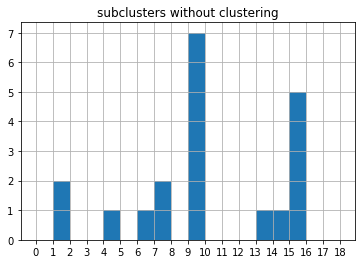

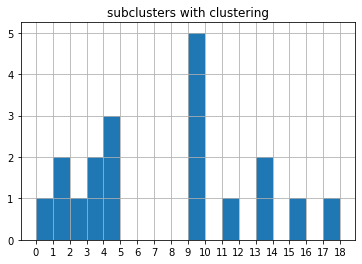

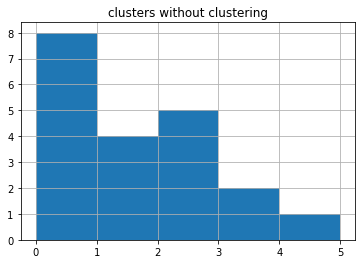

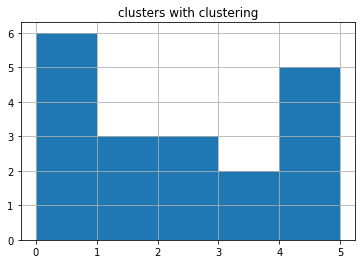

In [112]:
rec = recommend_without_clusters('z6gseuVl0cR7tRLQa_DXuQ', utility_matrix, similarity_avg)
rec2 = recommend('z6gseuVl0cR7tRLQa_DXuQ', utility_matrix, similarity_avg)

rec.hist(column='subcluster', bins=range(subcluster_amount))
plt.xticks(range(subcluster_amount))
plt.title('subclusters without clustering')

rec2.hist(column='subcluster', bins=range(subcluster_amount))
plt.xticks(range(subcluster_amount))
plt.title('subclusters with clustering')

rec.hist(column='cluster', bins=range(cluster_amount))
plt.title('clusters without clustering')

rec2.hist(column='cluster', bins=range(cluster_amount))
plt.title('clusters with clustering')


In [106]:
display(users)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,cFGAElozHTdQDfHimOiSBQ,Alexa,164,2008-09-05 07:13:34,715,318,394,"2015,2016,2017","db8n21wt96O2XmLn1WSidg, drVEocTGKbGRO9-b8Dve0g...",25,...,2,0,1,0,6,4,22,22,2,4
1,RZ1Fq9AuQ0OkRdTzpr1NvA,Helen,9,2010-05-10 19:08:38,35,32,35,,"dS2nxBC_PSHtPh2ZVNkvmQ, Gzw5r_LGZ_rOofc3u9gsSg...",2,...,0,0,0,0,0,0,0,0,0,0
2,7uWE7YWlRrde5fifL9KTuQ,Eric,24,2012-08-16 01:50:23,149,57,125,,"gBzcQ-FFvEVUdIxdUdf3EQ, sqJZt_Z144RWGk4bdKTpSw...",0,...,0,1,0,0,0,0,0,0,1,0
3,IdGt5n3oUA6-SBRfTPCLJg,Kim,46,2013-01-27 21:44:58,78,46,58,,"qmhD1iTfB5tx_tGjWTFOxw, R2w6YYFLndu0WXRq6pljqg...",0,...,1,0,0,0,1,2,0,0,0,0
4,AMdGLT8LlCeHcTFISfXQMA,Annie,27,2016-03-10 00:25:16,47,35,43,,"kebM1adVv3Tb4DB3C1TboA, BVVCNsLbNCzoDg2ByDFeyA...",0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11227,_PvyIrD0Mp-NswjUKv1URA,Deborah,147,2011-09-08 01:26:23,193,60,96,"2015,2016,2017,2018","dERyXf-mY20O8yTJVK1diA, mb_8jXannipO5T5V5kGXiQ...",14,...,1,0,0,0,1,8,10,10,6,5
11228,z6gseuVl0cR7tRLQa_DXuQ,Joey,342,2014-02-27 01:32:36,798,540,526,"2015,2016,2017","UbWH_Bx5H7O8_pqtANgLAw, hPIqzdmZdnCRL4FwhiCemA...",42,...,5,1,2,0,24,17,55,55,37,0
11229,JesJ-LaNfr3pKhL7gWhDrw,Amy,549,2013-06-03 23:30:34,3241,1927,1897,"2014,2015,2016,2017,2018","aLvxbF2DueKFOqul9eVWCw, peVsgFj0qa8SErmzIDM0lg...",236,...,8,2,6,1,67,319,168,168,39,57
11230,ib76pBD28PxZXKrVB-x_nQ,Chris,7,2014-12-06 00:12:04,0,0,0,,"PO3B74pWdwwn1zb0UJiKVA, 02CMC9fM8OBo3lpMaii3Dg...",0,...,0,0,0,0,0,0,0,0,0,0


-------------------------------------------------------------------------------------------------------------
<h4>The code below is depricated and was only left to prove that we implemented and investigated concepts mentioned in our reports and presentation</h4>

In [ ]:
# from nltk.corpus import wordnet as wn
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# import nltk
# from sklearn.feature_extraction.text import TfidfVectorizer

# stemmer = PorterStemmer()
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# punc = ['(', ')', '$', '&', '*']

# categories = businesses[businesses['categories'].notnull()]['categories'].copy()
# a, b, c = 0, 0, 0
# for i in categories.index:
#     new_category = []
#     sentence = categories[i]

#     for category in sentence.split():
#         for word in category.split():
#             word = word.replace(',', '')
#             if word in punc:
#                 continue

#             try:
#                 definition = wn.synsets(word)[0].definition()
#                 definition = word_tokenize(definition)
#                 definition =  [word for word in definition if word not in stop_words]

#                 stemmer = PorterStemmer()
#                 definition = [stemmer.stem(plural) for plural in definition]
#                 definition = [word for word in definition if word not in punc] 
#                 definition.append(word)

#                 new_category.extend(definition)

#             except:
#                 new_category.append(word)
            
#             try:
#                 definition = wn.synsets(word)[0].hypernyms()[0].definition()
#                 definition = word_tokenize(definition)
#                 definition =  [word for word in definition if word not in stop_words]

#                 stemmer = PorterStemmer()
#                 definition = [stemmer.stem(plural) for plural in definition]
#                 definition = [word for word in definition if word not in punc] 

#                 new_category.extend(definition)
#             except:
#                 pass


#     new_category = ', '.join(new_category)
#     categories.loc[i] = new_category
# print(a, b, c)
# display(categories)

# tdif = TfidfVectorizer().fit(categories)
# x_transformed = tdif.transform(categories).todense()


# n_components = 151

# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=n_components).fit(x_transformed)
# x_transformed = pca.transform(x_transformed) 
# explained = pca.explained_variance_ratio_.cumsum()

# plt.plot(range(1, n_components + 1), explained)
# plt.xlabel('amount of components')
# plt.ylabel('cumulative sum')
# plt.show()



In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# Sum_of_squared_distances = []
# silhoutte_score = []
# K = range(2, 100, 2)
# for k in K:
#     print('\r', k, end='')
#     km = KMeans(n_clusters=k, init='k-means++')
#     km = km.fit(x_transformed)
#     labels = km.predict(x_transformed)
#     Sum_of_squared_distances.append(km.inertia_)
#     silhoutte_score.append(silhouette_score(x_transformed, labels))


# import matplotlib.pyplot as plt

# plt.plot(K, silhoutte_score)
# plt.xlabel('k')
# plt.ylabel('Silhoutte score')
# plt.title('Silhoutte method for optimal k')
# plt.savefig('silhouette.png')

# plt.show()

# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.savefig('elbow.png')

# plt.show()

In [ ]:
# from sklearn.cluster import SpectralClustering
# import numpy as np
# from sklearn.metrics import silhouette_score

# silhoutte_score = []
# K = range(2,100, 10)
# for k in K:
#     print('\r', k, end='')
#     clustering = SpectralClustering(n_clusters=k, assign_labels='discretize').fit(x_transformed)
#     labels = clustering.labels_
#     silhoutte_score.append(silhouette_score(x_transformed, labels))


# import matplotlib.pyplot as plt

# plt.plot(K, silhoutte_score)
# plt.xlabel('k')
# plt.ylabel('Silhoutte score')
# plt.title('Silhoutte method for optimal k')
# plt.show()

